In [53]:
import os
import torch

import torch.nn as nn
import torchvision
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
import seaborn as sns


from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial.distance import pdist, squareform


In [54]:

base_dir = os.path.abspath('../..')
save_dir = os.path.join(base_dir,'results')
data_dir = os.path.join(base_dir,'data')
results_dir = os.path.join(base_dir,'results')

In [55]:
class TripletLabelModel(nn.Module):
    def __init__(self, encoded_space_dim=64, num_classes=4):
        super().__init__()
        ""
       ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        ## changed 32*4*4 to 32*2*2
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*2*2, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

        ## triplet projection module
        self.decoder_triplet_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True)
         
        )
        ##labeling module
        self.decoder_labels_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, num_classes),
        )

        ### initialize weights using xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x, y=None):
        batch_s = x.size(0)
        img_features = self.encoder_cnn(x)
        img_features = self.flatten(img_features)
        
        enc_latent = self.encoder_lin(img_features)

        triplet_latent = self.decoder_triplet_lin(enc_latent)
        label = self.decoder_labels_lin(enc_latent)
        # label = F.softmax(label,dim=1)
        return enc_latent, label

In [56]:
v_ims = np.load(os.path.join(data_dir,'validation_set.npy')) ## validation images
v_labels = np.load(os.path.join(data_dir,'validation_labs.npy')) ### validation labels

In [57]:
nn_model = TripletLabelModel()

model_list = os.listdir(results_dir)
model_list = sorted(model_list)

In [58]:
v_ims.shape

(480, 64, 64, 3)

In [59]:
model_list

['set_A_label_0.pth',
 'set_A_label_and_triplet_0.pth',
 'set_A_triplet_0.pth',
 'set_B_label_0.pth',
 'set_B_label_and_triplet_0.pth',
 'set_B_triplet_0.pth',
 'set_C_label_0.pth',
 'set_C_label_and_triplet_0.pth',
 'set_C_triplet_0.pth']

0.8875
0.8833333333333333
0.2916666666666667
0.86875
0.8583333333333333
0.2625
0.8770833333333333
0.8708333333333333
0.26666666666666666


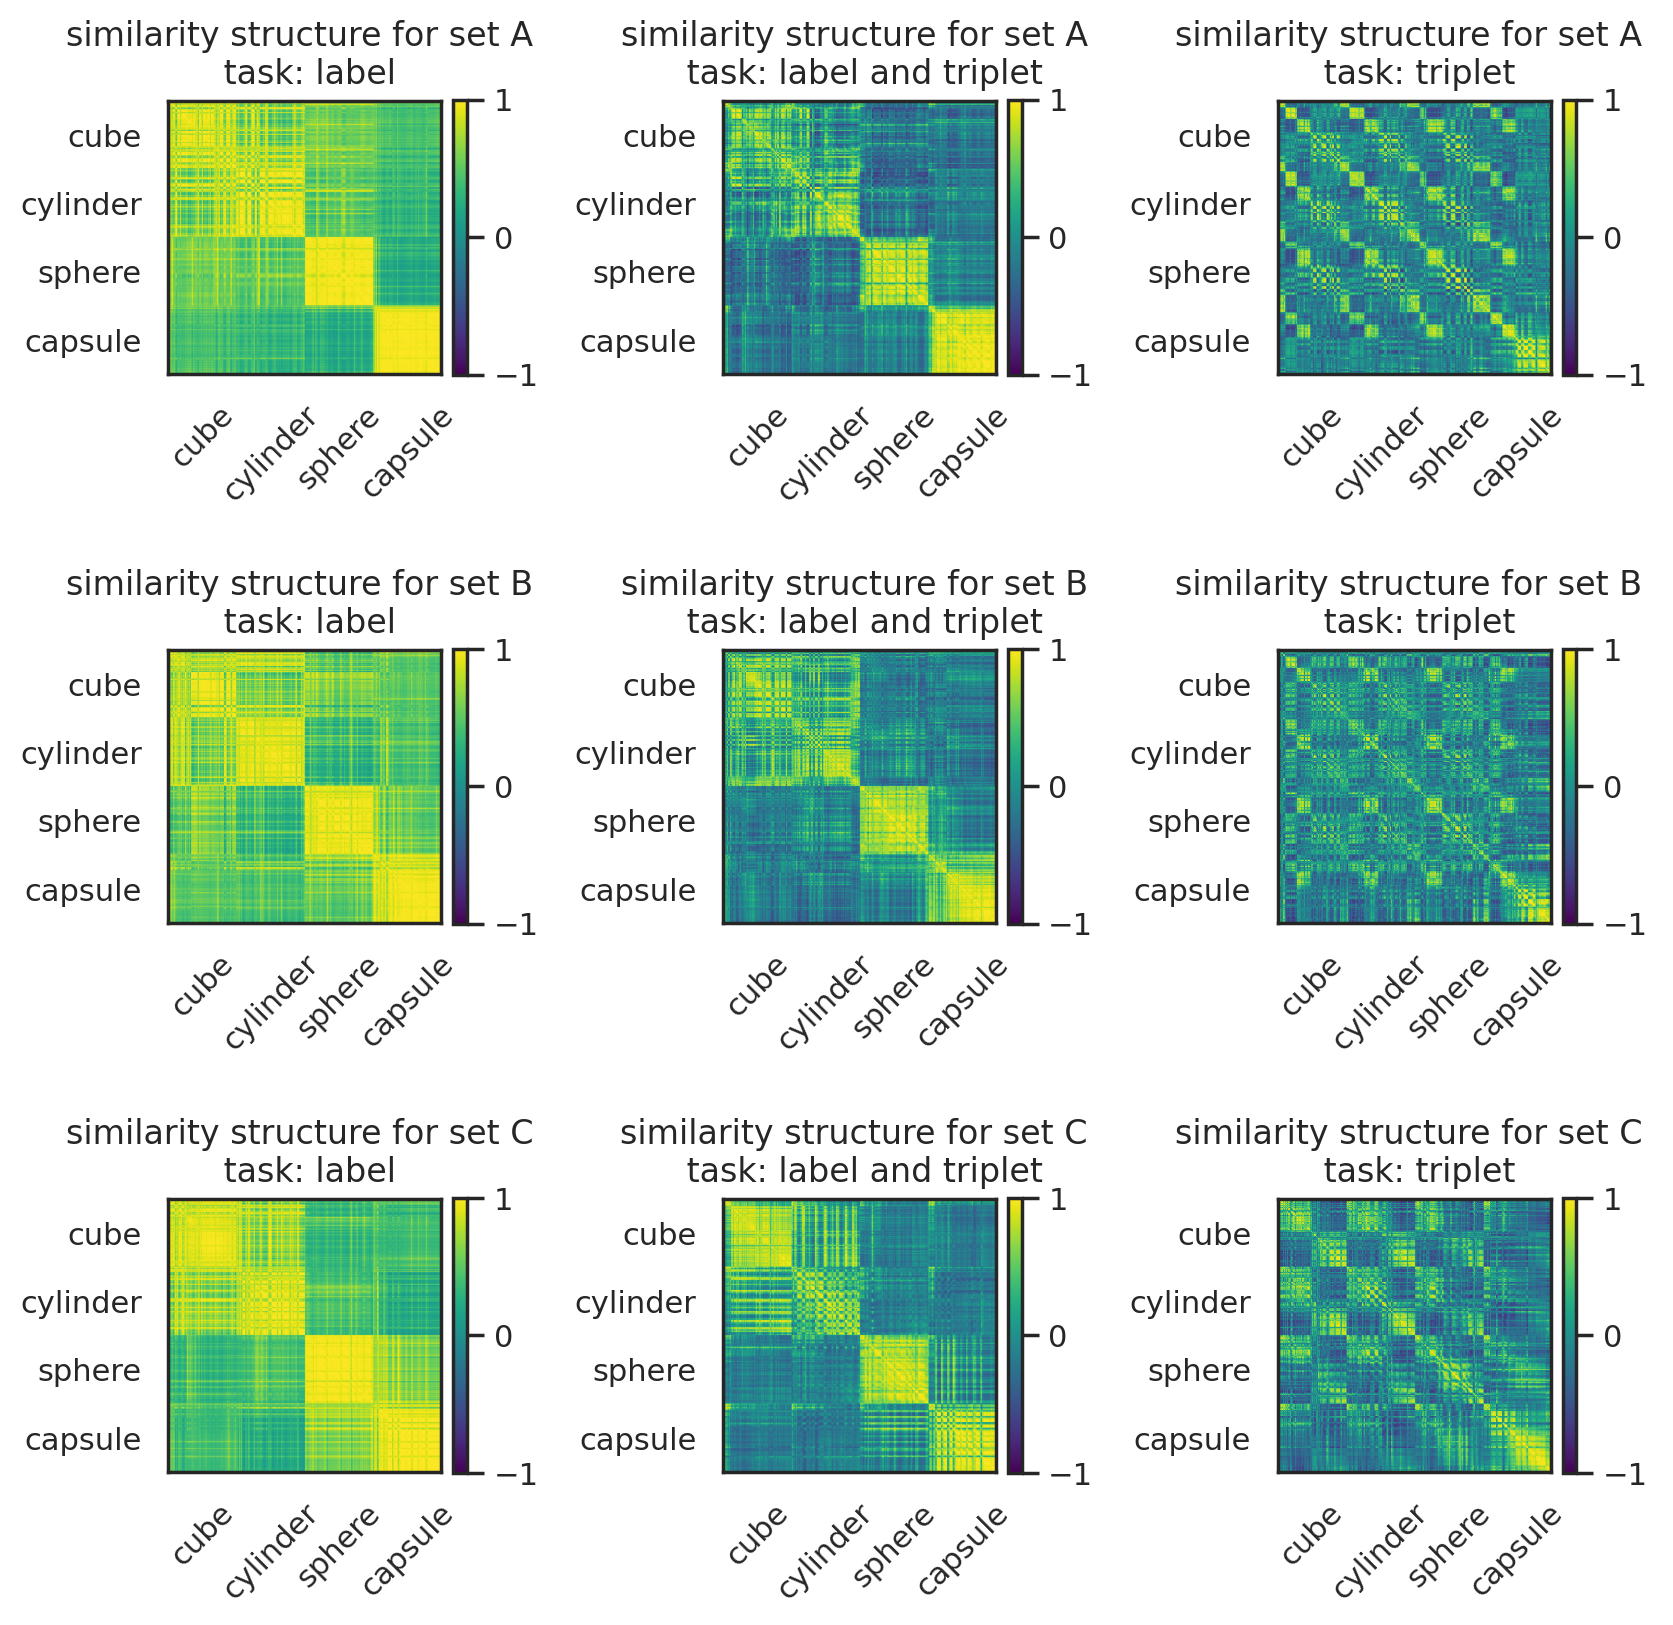

In [60]:
accs = []
tasks = []


latents_df =pd.DataFrame(columns=['dataset','task','latent'])
fig, axes = plt.subplots(3,3,figsize=(8.5,8.5))

for i, this_model in enumerate(model_list):
    ax = axes.flatten()[i]
    nn_model.load_state_dict(torch.load(os.path.join(results_dir,this_model)))
    # nn_model.load_state_dict(torch.load(cifar_model))
    ### pass v_ims through the model but make sure to transpose the image dimensions first
    v_ims_t = torch.from_numpy(v_ims.transpose(0,3,1,2)).float()
    v_ims_t = v_ims_t/255.0
    v_ims_t = Resize(32)(v_ims_t)

    ### now pass v_ims through the model
    latents, labels = nn_model(v_ims_t)

    ### do an argmax on the labels to get the predicted labels
    pred_labels = torch.argmax(labels,dim=1)
    pred_labels = pred_labels.detach().numpy()

    correct = 0
    for j in range(len(pred_labels)):
        if pred_labels[j] == v_labels[j]:
            correct += 1
    print(correct/len(pred_labels))
    accs.append(correct/len(pred_labels))
    tasks.append(this_model.split('_', 2)[2].rsplit('_', 1)[0])


    # Compute pairwise cosine similarities
    cos_sim = cosine_similarity(latents.detach().numpy())

    # Plot heatmap
    im = ax.imshow(cos_sim, cmap='viridis', vmin=-1, vmax=1)
    cbar = ax.figure.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    cbar.set_ticks([-1,0,1])


    ax.set_xticks([60,180,300,420],['cube','cylinder','sphere','capsule'], rotation=45)
    ax.set_yticks([60,180,300,420],['cube','cylinder','sphere','capsule'])



    task_string = this_model.split('_', 2)[2]
    task_string = task_string.rsplit('_', 1)[0].replace('_', ' ')


   
    ax.set_title(f'similarity structure for set {this_model.split("_")[1]} \n task: {task_string}')
    fig.tight_layout()

    latents_df.loc[i,'dataset'] = this_model.split("_")[1]
    latents_df.loc[i,'task'] = task_string.replace(' ', '_')
    latents_df.loc[i,'latent'] = latents.detach().numpy()
    

plt.show()




(0.0, 1.0)

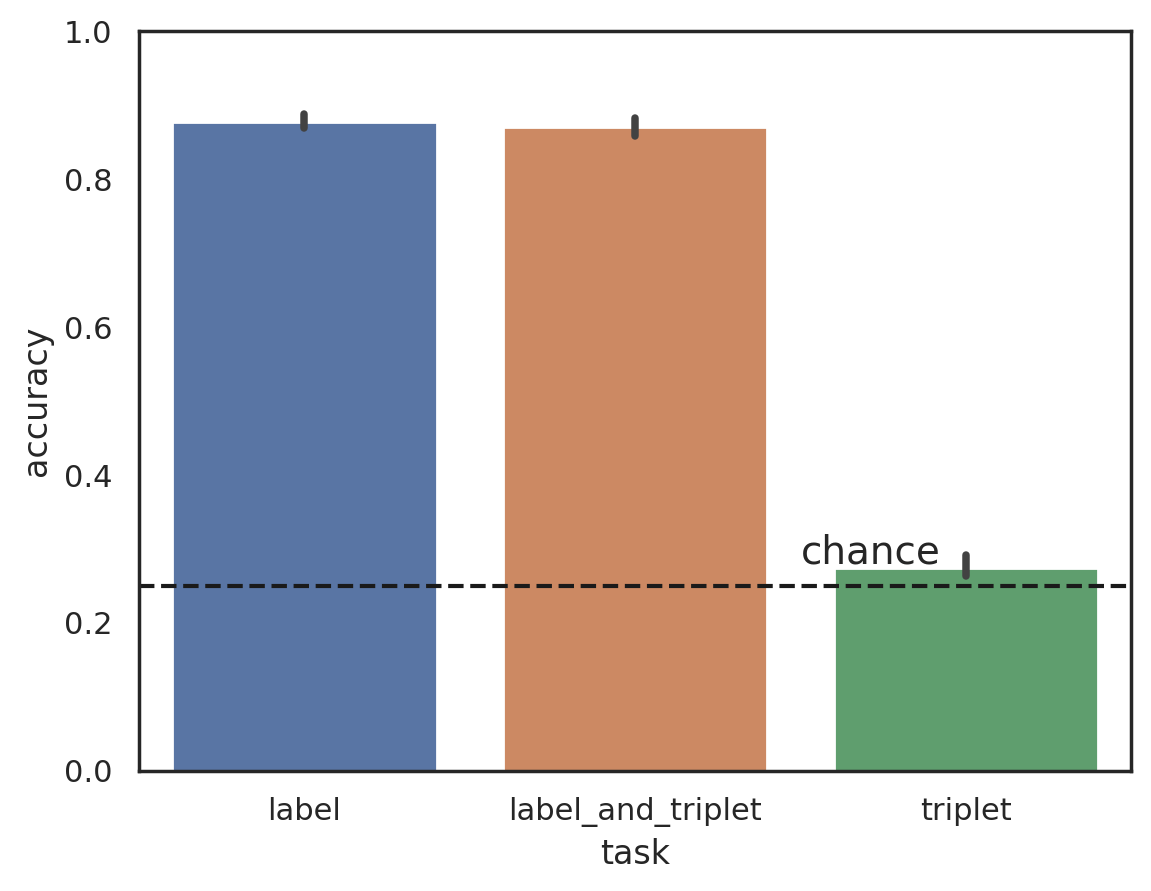

In [61]:
acc_df = pd.DataFrame({'task':tasks,'accuracy':accs})
sns.barplot(x='task',y='accuracy',data=acc_df)
## add a horizontal line at 0.25 and annotate it with the word 'chance'
plt.axhline(0.25,ls='--',color='k')
plt.text(1.5,0.28,'chance',fontsize=14)
plt.ylim([0,1])


In [62]:
# latents_df = latents_df[latents_df['task']!='label']
latents_df

,dataset,task,latent
0,A,label,"[[-2.2307281, 1.1778576, 3.9477105, 1.6195582,..."
1,A,label_and_triplet,"[[-1.0157567, 0.17278983, -1.6196665, 2.773741..."
2,A,triplet,"[[-0.3538805, 0.75016403, -0.44531095, 0.79909..."
3,B,label,"[[5.827639, 5.0118833, 4.6300187, 0.25299087, ..."
4,B,label_and_triplet,"[[0.7708935, 2.3625257, -1.4322563, 0.13033296..."
5,B,triplet,"[[0.8546328, -0.6263804, 0.0023019696, 0.11196..."
6,C,label,"[[2.181884, 3.1761827, 0.6190741, -2.9730701, ..."
7,C,label_and_triplet,"[[-0.27185306, 0.93218696, -0.367044, -0.79842..."
8,C,triplet,"[[-1.720722, -0.002920867, -0.05129105, 1.4857..."


In [63]:
tasks=[]
overlaps = []
withins = []
betweens = []
for this_task in latents_df['task'].unique():
   ds = latents_df[latents_df['task']==this_task]
   distA = pdist(ds[ds.dataset=='A']['latent'].values[0], metric='cosine')
   distB = pdist(ds[ds.dataset=='B']['latent'].values[0], metric='cosine')
   distC = pdist(ds[ds.dataset=='C']['latent'].values[0], metric='cosine')

   blocksize = 120
   block_diag = np.zeros((480,480))
   for i in range(4):
      block_diag[i*blocksize:(i+1)*blocksize,i*blocksize:(i+1)*blocksize] = 1

   ### mask distA with block_diag
   within_distA = squareform(distA)*block_diag
   between_distA = squareform(distA)*(1-block_diag)
   within_distB = squareform(distB)*block_diag
   between_distB = squareform(distB)*(1-block_diag)
   within_distC = squareform(distC)*block_diag
   between_distC = squareform(distC)*(1-block_diag)




   ### compute distance matrices and get lower triangles
   dmatA_within = np.tril(within_distA,k=-1).flatten()
   dmatB_within = np.tril(within_distB,k=-1).flatten()
   dmatC_within = np.tril(within_distC,k=-1).flatten()

   dmatA_between = np.tril(between_distA,k=-1).flatten()
   dmatB_between = np.tril(between_distB,k=-1).flatten()
   dmatC_between = np.tril(between_distC,k=-1).flatten()


   # AB_sim = np.corrcoef(dmatA,dmatB)[0,1]
   # AC_sim = np.corrcoef(dmatA,dmatC)[0,1]
   # BC_sim = np.corrcoef(dmatB,dmatC)[0,1]

   AB_within_sim = np.corrcoef(dmatA_within,dmatB_within)[0,1]
   AC_within_sim = np.corrcoef(dmatA_within,dmatC_within)[0,1]
   BC_within_sim = np.corrcoef(dmatB_within,dmatC_within)[0,1]

   AB_between_sim = np.corrcoef(dmatA_between,dmatB_between)[0,1]
   AC_between_sim = np.corrcoef(dmatA_between,dmatC_between)[0,1]
   BC_between_sim = np.corrcoef(dmatB_between,dmatC_between)[0,1]
   print(f'{this_task} results')
   print(f'AB within category similarity for {this_task} is {AB_within_sim}')
   print(f'AC within category similarity for {this_task} is {AC_within_sim}')
   print(f'BC within category similarity for {this_task} is {BC_within_sim}')
   print('')
   print(f'AB between category similarity for {this_task} is {AB_between_sim}')
   print(f'AC between category similarity for {this_task} is {AC_between_sim}')
   print(f'BC between category similarity for {this_task} is {BC_between_sim}')
   print('')
   tasks.append([this_task]*3)
   overlaps.append([50,0,33.33])
   withins.append([AB_within_sim,AC_within_sim,BC_within_sim])
   betweens.append([AB_between_sim,AC_between_sim,BC_between_sim])






label results
AB within category similarity for label is 0.5244216595082719
AC within category similarity for label is 0.48395131347486386
BC within category similarity for label is 0.5416549948608669

AB between category similarity for label is 0.8439661531654139
AC between category similarity for label is 0.8278876087719945
BC between category similarity for label is 0.8631571040762375

label_and_triplet results
AB within category similarity for label_and_triplet is 0.7815532062019116
AC within category similarity for label_and_triplet is 0.701796936958572
BC within category similarity for label_and_triplet is 0.7136597064886819

AB between category similarity for label_and_triplet is 0.9326608275621138
AC between category similarity for label_and_triplet is 0.9253273337958074
BC between category similarity for label_and_triplet is 0.9258295825576575

triplet results
AB within category similarity for triplet is 0.9062618006645449
AC within category similarity for triplet is 0.8593867

In [64]:
sim_df = pd.DataFrame({'task':np.array(tasks).flatten(), 'overlap':np.array(overlaps).flatten(),'within':np.array(withins).flatten(),'between':np.array(betweens).flatten()})
sim_df['accuracy']=accs
sim_df

,task,overlap,within,between,accuracy
0,label,50.00,0.524422,0.843966,0.887500
1,label,0.00,0.483951,0.827888,0.883333
2,label,33.33,0.541655,0.863157,0.291667
3,label_and_triplet,50.00,0.781553,0.932661,0.868750
4,label_and_triplet,0.00,0.701797,0.925327,0.858333
5,label_and_triplet,33.33,0.713660,0.925830,0.262500
6,triplet,50.00,0.906262,0.896374,0.877083
7,triplet,0.00,0.859387,0.855511,0.870833
8,triplet,33.33,0.863260,0.860259,0.266667


In [65]:

sim_df = pd.melt(sim_df, id_vars=['task','overlap','accuracy'], value_vars=['within','between'])

sim_df.columns = ['task','overlap','accuracy','category','similarity']
sim_df

,task,overlap,accuracy,category,similarity
0,label,50.00,0.887500,within,0.524422
1,label,0.00,0.883333,within,0.483951
2,label,33.33,0.291667,within,0.541655
3,label_and_triplet,50.00,0.868750,within,0.781553
4,label_and_triplet,0.00,0.858333,within,0.701797
5,label_and_triplet,33.33,0.262500,within,0.713660
6,triplet,50.00,0.877083,within,0.906262
7,triplet,0.00,0.870833,within,0.859387
8,triplet,33.33,0.266667,within,0.863260
9,label,50.00,0.887500,between,0.843966


(0.0, 1.0)

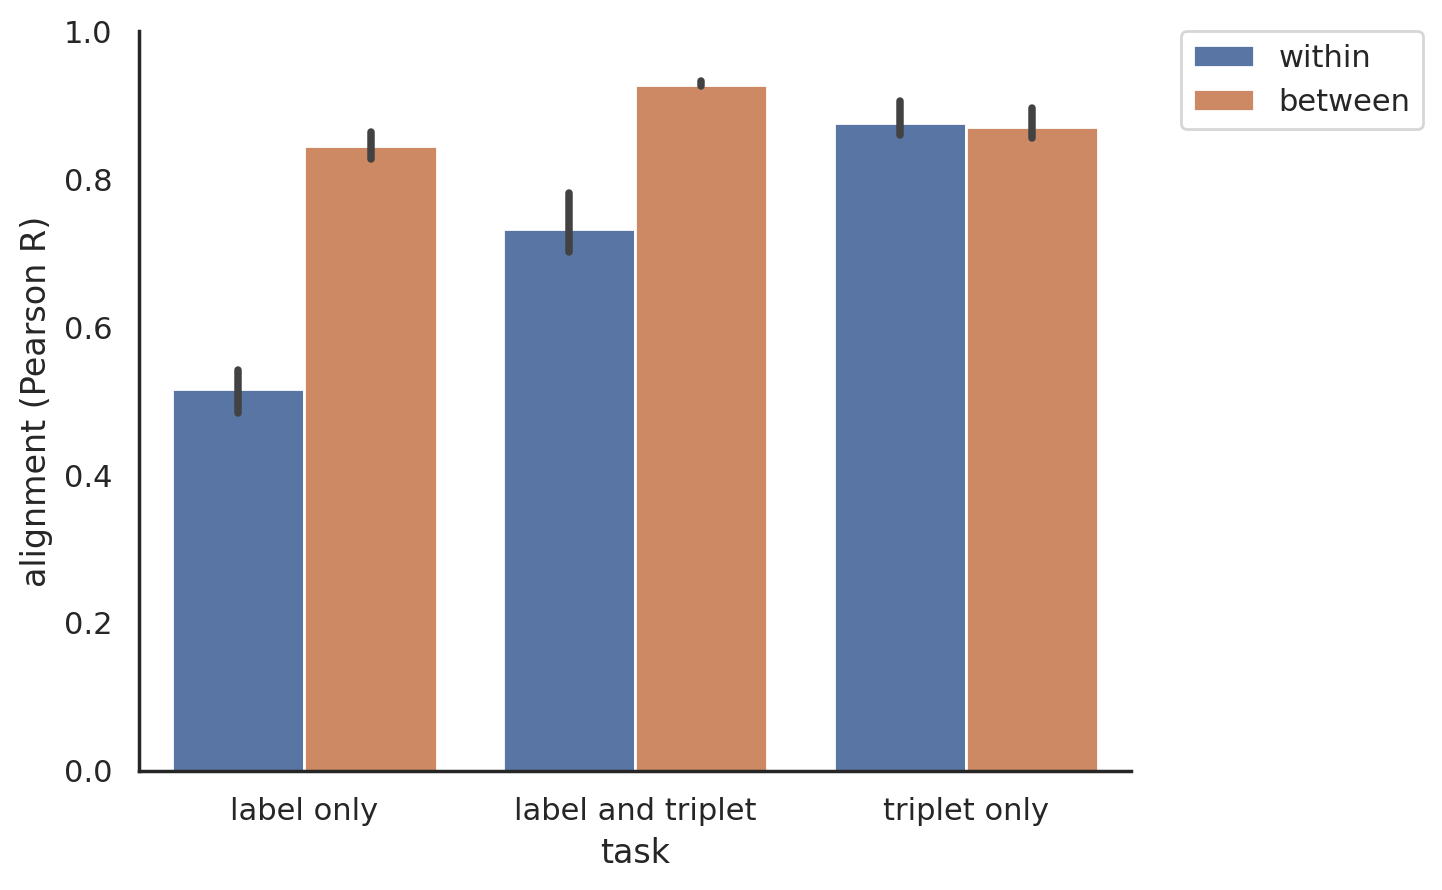

In [66]:

sns.set_theme(style="white")
sns.barplot(x="task", y="similarity", hue="category", data=sim_df)
sns.despine()
### move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('alignment (Pearson R)')
plt.xticks([0,1,2],['label only','label and triplet', 'triplet only'])
plt.ylim([0,1])

(0.0, 1.0)

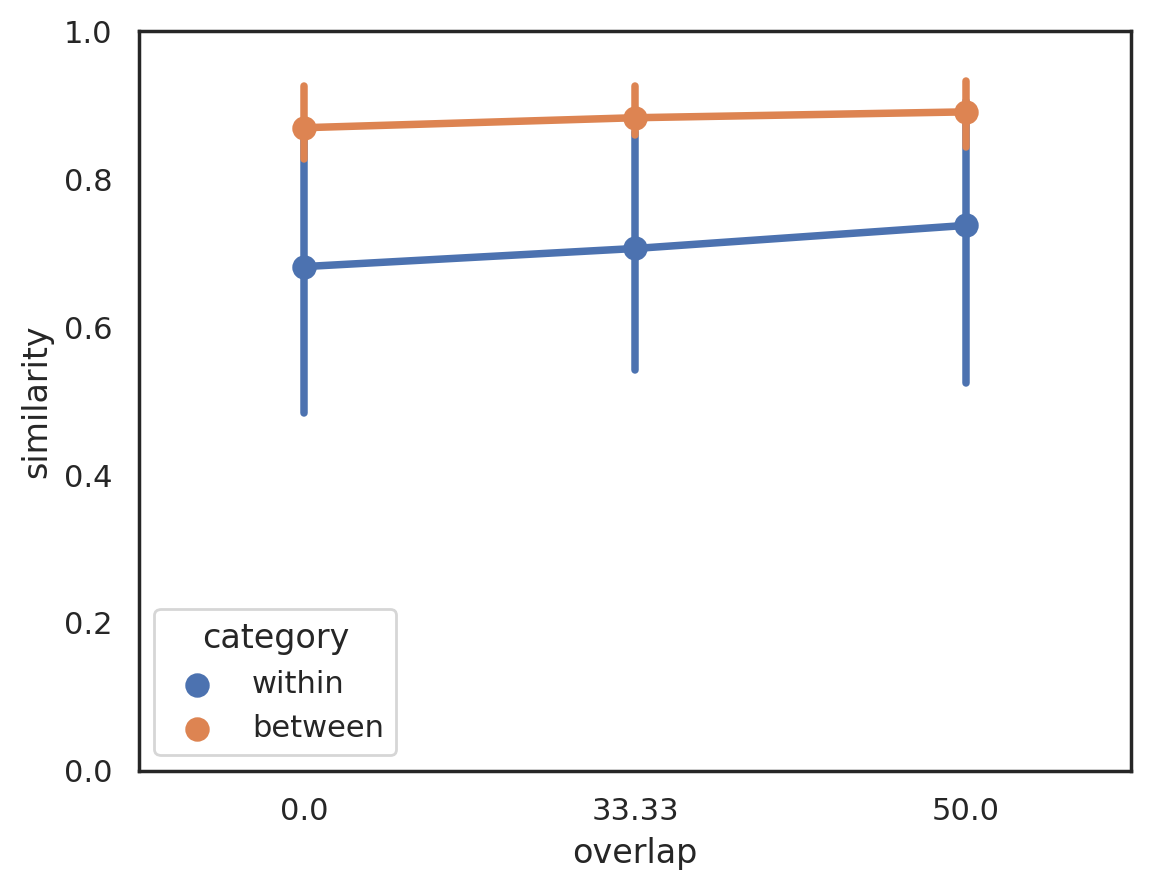

In [67]:
sns.set_theme(style="white")
sns.pointplot(x="overlap", y="similarity", hue='category', data=sim_df)
plt.ylim([0,1])